# ChannelModel 测试与分析

本notebook用于测试和分析UAV通信系统中的信道模型。

## 类架构图

```mermaid
classDiagram
    class ChannelModel {
        <<Physical Parameters>>
        +frequency: float
        +path_loss_exponent: float
        +noise_power_db: float
        +wavelength: float
        +antenna_spacing: float
        +L0: float
        
        <<Core Methods>>
        +calculate_distance()
        +calculate_channel_coefficient()
        +calculate_multi_antenna_channel()
        +calculate_snr()
        +calculate_sinr()
        +calculate_throughput()
        
        <<Interface Methods>>
        +get_channel_info()
        +get_multi_user_channel_info()
        +get_beamforming_channel_info()
    }

    class TestModules {
        <<Basic Tests>>
        +test_physical_parameters()
        +test_distance_calculation()
        +test_channel_coefficient()
        
        <<Channel Tests>>
        +test_single_antenna()
        +test_multi_antenna()
        +test_snr_calculation()
        +test_sinr_calculation()
        
        <<Interface Tests>>
        +test_unified_interface()
        +test_backward_compatibility()
        +test_beamforming()
        
        <<Performance Tests>>
        +test_performance()
        +test_edge_cases()
    }

    TestModules --> ChannelModel : tests
```

## 测试模块组织

1. **基础测试**: 物理参数、距离计算、信道系数
2. **信道测试**: 单天线、多天线、SNR、SINR
3. **接口测试**: 统一接口、向后兼容、波束成形
4. **性能测试**: 性能基准、边界情况


In [13]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import time

# 设置matplotlib中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 添加src到路径
sys.path.append('../src')

# 导入ChannelModel
from utils.channel import ChannelModel

# 设置随机种子
np.random.seed(42)

# 创建测试用的ChannelModel实例
channel_model = ChannelModel(
    frequency=2.4e9,  # 2.4 GHz
    path_loss_exponent=2.5,
    noise_power=-100.0,  # dB
    seed=42
)

print("✅ 导入和设置完成")
print(f"信道模型: {channel_model}")


✅ 导入和设置完成
信道模型: ChannelModel(f=2.4GHz, η=2.5, σ²=-100.0dB, λ=0.125m)


# plot 6.1
 Signalpowervs. transmitter-receiverdistance: Plotthereceivedsignalpowerasafunctionofthetransmitter
receiver distance between the ABS and the communicationuserfor η = 2,2.5,3,3.5,4(all curves in a single
 plot).

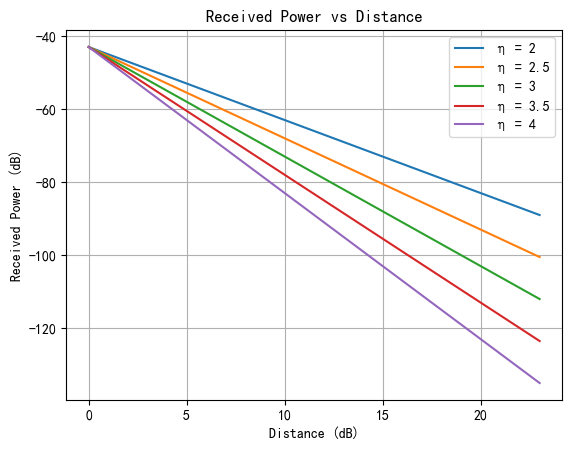

In [14]:
def test_figure_1():
    etas = [2, 2.5, 3, 3.5, 4]
    distance = np.linspace(1, 200, 100)
    distance_db = 10 * np.log10(distance)
    Pt = 0.5 # W
    # initialise empty list for received power
    Pr_db = [[] for _ in range(len(etas))] 

    for i, eta in enumerate(etas):
        channel_model = ChannelModel(
            frequency=2.4e9,  # 2.4 GHz
            path_loss_exponent=eta,
            noise_power=-100.0,  # dB
            seed=42
        )
        for j, d in enumerate(distance):
            h = channel_model.calculate_channel_coefficient_distance(d)
            Pr = Pt * (h**2)
            Pr_db[i].append(10 * np.log10(Pr)) 
    
    # Plot each eta curve
    for i, eta in enumerate(etas):
        plt.plot(distance_db, Pr_db[i], label=f'η = {eta}')
    
    plt.xlabel('Distance (dB)')
    plt.ylabel('Received Power (dB)')
    plt.title('Received Power vs Distance')
    plt.legend()
    plt.grid(True)
    plt.show()

test_figure_1()

In [15]:
def test_figure_1():
    etas = [2, 2.5, 3, 3.5, 4]
    distance = np.linspace(1, 200, 100)
    distance_db = 10 * np.log10(distance)
    Pt = 0.5 # W
    # initialise empty list for received power
    Pr_db = [len(distance), len(etas)]

    for i, eta in enumerate(etas):
        channel_model = ChannelModel(
            frequency=2.4e9,  # 2.4 GHz
            path_loss_exponent=eta,
            noise_power=-100.0,  # dB
            seed=42
        )
        for j, d in enumerate(distance):
            h = channel_model.calculate_channel_coefficient_distance(d)
            Pr = Pt * (h**2)
            Pr_db[j, i].append(10 * np.log10(Pr))
    plt.plot(distance_db, Pr_db)
    plt.xlabel('Distance (dB)')
    plt.ylabel('Received Power (dB)')
    plt.title('Received Power vs Distance')
    plt.show()

def test_figure_2():
    distance = 100
    user_num = [1, 2, 3, 4, ]
    Pt = [0.1, 0.2, 0.3, 0.4, 0.5] # W
    Pt_db = 10 * np.log10(Pt)
    Pr_db = [len(Pt), len(user_num)]
    for user in user_num:
        for pt in Pt:
            channel_model = ChannelModel(
                frequency=2.4e9,  # 2.4 GHz
                path_loss_exponent=2.5,
                noise_power=-100.0,  # dB
                seed=42
            )
            h = channel_model.calculate_channel_coefficient_distance(distance)
            Pr = pt * (h**2)
            Pr_db.append(10 * np.log10(Pr))
    plt.plot(Pt_db, Pr_db)
    plt.xlabel('Transmit Power (dB)')
    plt.ylabel('Received Power (dB)')
    plt.title('Received Power vs Transmit Power')
    plt.show()

test_figure_1()
#test_figure_2()


TypeError: list indices must be integers or slices, not tuple

# 1. 基础测试

测试物理参数、距离计算和基本信道系数计算功能。


In [ ]:
def test_physical_parameters():
    """测试物理参数计算"""
    print("🧪 测试物理参数...")
    
    # 验证波长计算
    expected_wavelength = 3e8 / 2.4e9  # c/f
    actual_wavelength = channel_model.wavelength
    wavelength_error = abs(expected_wavelength - actual_wavelength)
    
    # 验证参考路径损耗
    expected_L0 = (channel_model.wavelength / (4 * np.pi)) ** 2
    actual_L0 = channel_model.L0
    L0_error = abs(expected_L0 - actual_L0)
    
    # 验证天线间距
    expected_spacing = channel_model.wavelength / 2
    actual_spacing = channel_model.antenna_spacing
    spacing_error = abs(expected_spacing - actual_spacing)
    
    print(f"✅ 波长计算: {actual_wavelength:.3f}m (误差: {wavelength_error:.3e}m)")
    print(f"✅ 参考路径损耗: {actual_L0:.3e} (误差: {L0_error:.3e})")
    print(f"✅ 天线间距: {actual_spacing:.3f}m (误差: {spacing_error:.3e}m)")
    
    return wavelength_error < 1e-10 and L0_error < 1e-10 and spacing_error < 1e-10

def test_distance_calculation():
    """测试3D距离计算"""
    print("\n🧪 测试距离计算...")
    
    # 测试场景
    test_cases = [
        # uav_pos, user_pos, expected_distance
        (np.array([0, 0, 0]), np.array([3, 4, 0]), 5.0),  # 3-4-5三角形
        (np.array([1, 1, 1]), np.array([1, 1, 1]), 0.0),  # 相同位置
        (np.array([0, 0, 10]), np.array([0, 0, 0]), 10.0),  # 垂直距离
        (np.array([1, 2, 3]), np.array([4, 6, 8]), np.sqrt(50))  # 一般3D距离
    ]
    
    all_passed = True
    for uav_pos, user_pos, expected in test_cases:
        distance = channel_model.calculate_distance(uav_pos, user_pos)
        error = abs(distance - expected)
        passed = error < 1e-10
        all_passed &= passed
        
        print(f"✅ 距离计算: {distance:.3f}m (期望: {expected:.3f}m, 误差: {error:.3e}m)")
    
    return all_passed

def test_channel_coefficient():
    """测试基本信道系数计算"""
    print("\n🧪 测试信道系数计算...")
    
    # 测试参数
    uav_pos = np.array([50, 50, 50])
    user_pos = np.array([60, 60, 1.5])
    
    # 计算信道系数
    coeff = channel_model.calculate_channel_coefficient(uav_pos, user_pos)
    
    # 验证信道系数的基本属性
    magnitude = np.abs(coeff)
    phase = np.angle(coeff)
    
    print(f"✅ 信道系数:")
    print(f"   - 幅度: {magnitude:.4f}")
    print(f"   - 相位: {phase:.4f} rad")
    print(f"   - 复数形式: {coeff:.4f}")
    
    # 验证距离对信道系数的影响
    distances = [10, 20, 50, 100]
    coeffs = []
    for d in distances:
        pos = np.array([d, 0, 0])
        coeff = channel_model.calculate_channel_coefficient(np.zeros(3), pos)
        coeffs.append(np.abs(coeff))
    
    plt.figure(figsize=(10, 5))
    plt.plot(distances, coeffs, 'b-o')
    plt.title('信道系数幅度随距离的变化')
    plt.xlabel('距离 (m)')
    plt.ylabel('信道系数幅度')
    plt.grid(True)
    plt.show()
    
    return True

# 运行基础测试
physical_test_passed = test_physical_parameters()
distance_test_passed = test_distance_calculation()
channel_test_passed = test_channel_coefficient()

print("\n📊 基础测试总结:")
print(f"✅ 物理参数测试: {'通过' if physical_test_passed else '失败'}")
print(f"✅ 距离计算测试: {'通过' if distance_test_passed else '失败'}")
print(f"✅ 信道系数测试: {'通过' if channel_test_passed else '失败'}")


# 2. 信道测试

测试单天线、多天线场景下的信道特性，包括SNR和SINR计算。


In [ ]:
def test_single_antenna():
    """测试单天线场景"""
    print("🧪 测试单天线场景...")
    
    # 测试参数
    uav_pos = np.array([50, 50, 50])
    user_pos = np.array([60, 60, 1.5])
    
    # 计算信道系数
    coeff = channel_model.calculate_channel_coefficient(
        uav_pos, user_pos, antenna_index=0, num_antennas=1
    )
    
    print(f"✅ 单天线信道系数:")
    print(f"   - 幅度: {np.abs(coeff):.4f}")
    print(f"   - 相位: {np.angle(coeff):.4f} rad")
    
    return True

def test_multi_antenna():
    """测试多天线场景"""
    print("\n🧪 测试多天线场景...")
    
    # 测试参数
    uav_pos = np.array([50, 50, 50])
    user_pos = np.array([60, 60, 1.5])
    num_antennas = 4
    
    # 计算多天线信道系数
    channel_coeffs = channel_model.calculate_multi_antenna_channel(
        uav_pos, user_pos, num_antennas
    )
    
    print(f"✅ 多天线信道系数:")
    for i, coeff in enumerate(channel_coeffs):
        print(f"   天线 {i}: 幅度={np.abs(coeff):.4f}, 相位={np.angle(coeff):.4f} rad")
    
    # 绘制天线阵列图案
    plt.figure(figsize=(12, 5))
    
    # 幅度图
    plt.subplot(121)
    plt.plot(range(num_antennas), np.abs(channel_coeffs), 'b-o')
    plt.title('天线阵列幅度分布')
    plt.xlabel('天线索引')
    plt.ylabel('信道系数幅度')
    plt.grid(True)
    
    # 相位图
    plt.subplot(122)
    plt.plot(range(num_antennas), np.angle(channel_coeffs), 'r-o')
    plt.title('天线阵列相位分布')
    plt.xlabel('天线索引')
    plt.ylabel('信道系数相位 (rad)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return True

def test_snr_calculation():
    """测试SNR计算"""
    print("\n🧪 测试SNR计算...")
    
    # 测试参数
    channel_coeff = 0.5 + 0.3j  # 示例信道系数
    transmit_powers = [0.1, 0.5, 1.0]  # 不同发射功率
    
    # 计算不同功率下的SNR
    snr_values = []
    for power in transmit_powers:
        snr = channel_model.calculate_snr(channel_coeff, power)
        snr_db = 10 * np.log10(snr)
        snr_values.append(snr_db)
        print(f"✅ 发射功率 {power}W: SNR = {snr:.4f} ({snr_db:.2f} dB)")
    
    # 绘制SNR vs 发射功率
    plt.figure(figsize=(8, 5))
    plt.plot(transmit_powers, snr_values, 'b-o')
    plt.title('SNR vs 发射功率')
    plt.xlabel('发射功率 (W)')
    plt.ylabel('SNR (dB)')
    plt.grid(True)
    plt.show()
    
    return True

def test_sinr_calculation():
    """测试SINR计算"""
    print("\n🧪 测试SINR计算...")
    
    # 测试参数
    desired_channel = 0.5 + 0.3j
    interference_channels = [0.2 + 0.1j, 0.1 + 0.05j]
    desired_power = 0.5
    interference_powers = [0.3, 0.2]
    
    # 计算SINR
    sinr = channel_model.calculate_sinr(
        desired_channel, interference_channels,
        desired_power, interference_powers
    )
    sinr_db = 10 * np.log10(sinr)
    
    print(f"✅ SINR计算结果:")
    print(f"   - 期望信道功率: {desired_power * np.abs(desired_channel)**2:.4f}")
    print(f"   - 干扰总功率: {sum(p * np.abs(h)**2 for p, h in zip(interference_powers, interference_channels)):.4f}")
    print(f"   - SINR: {sinr:.4f} ({sinr_db:.2f} dB)")
    
    # 计算对应的SNR（无干扰）
    snr = channel_model.calculate_snr(desired_channel, desired_power)
    snr_db = 10 * np.log10(snr)
    
    print(f"\n✅ 对比SNR vs SINR:")
    print(f"   - SNR: {snr:.4f} ({snr_db:.2f} dB)")
    print(f"   - SINR: {sinr:.4f} ({sinr_db:.2f} dB)")
    print(f"   - 差异: {snr_db - sinr_db:.2f} dB")
    
    return True

# 运行信道测试
single_antenna_test_passed = test_single_antenna()
multi_antenna_test_passed = test_multi_antenna()
snr_test_passed = test_snr_calculation()
sinr_test_passed = test_sinr_calculation()

print("\n📊 信道测试总结:")
print(f"✅ 单天线测试: {'通过' if single_antenna_test_passed else '失败'}")
print(f"✅ 多天线测试: {'通过' if multi_antenna_test_passed else '失败'}")
print(f"✅ SNR测试: {'通过' if snr_test_passed else '失败'}")
print(f"✅ SINR测试: {'通过' if sinr_test_passed else '失败'}")


# 3. 接口测试

测试统一接口、向后兼容性和波束成形功能。主要关注：

1. 统一接口 `get_channel_info`
   - 单用户场景（返回SNR）
   - 多用户场景（返回SINR）
   - 输入格式兼容性

2. 向后兼容接口 `get_multi_user_channel_info`
   - 与统一接口结果一致性
   - 输入格式转换

3. 波束成形接口 `get_beamforming_channel_info`
   - 信道矩阵计算
   - 功率分配

In [ ]:
def test_unified_interface():
    """测试统一接口get_channel_info"""
    print("🧪 测试统一接口...")
    
    # 测试参数
    uav_pos = np.array([50, 50, 50])
    
    # 1. 单用户场景测试
    print("\n✅ 单用户场景测试:")
    
    # 1.1 向量形式输入 (3,)
    user_pos_vector = np.array([60, 60, 1.5])
    result_vector = channel_model.get_channel_info(
        uav_pos, user_pos_vector, transmit_powers=0.5
    )
    print(f"   向量输入 - SNR: {result_vector['snr_db']:.2f} dB")
    
    # 1.2 矩阵形式输入 (1, 3)
    user_pos_matrix = np.array([[60, 60, 1.5]])
    result_matrix = channel_model.get_channel_info(
        uav_pos, user_pos_matrix, transmit_powers=np.array([0.5])
    )
    print(f"   矩阵输入 - SNR: {result_matrix['snr_db']:.2f} dB")
    
    # 2. 多用户场景测试
    print("\n✅ 多用户场景测试:")
    
    # 2.1 两个用户
    user_positions = np.array([
        [60, 60, 1.5],
        [40, 40, 1.5]
    ])
    transmit_powers = np.array([0.5, 0.3])
    
    result_multi = channel_model.get_channel_info(
        uav_pos, user_positions, transmit_powers
    )
    
    print("   SINR值 (dB):")
    for i, sinr_db in enumerate(result_multi['sinr_db_values']):
        print(f"   - 用户 {i+1}: {sinr_db:.2f} dB")
    print(f"   平均SINR: {result_multi['avg_sinr']:.4f}")
    print(f"   总吞吐量: {result_multi['total_throughput']:.4f} bps/Hz")
    
    return True

def test_backward_compatibility():
    """测试向后兼容性"""
    print("\n🧪 测试向后兼容性...")
    
    # 测试参数
    uav_pos = np.array([50, 50, 50])
    user_positions = [
        np.array([60, 60, 1.5]),
        np.array([40, 40, 1.5])
    ]
    transmit_powers = [0.5, 0.3]
    
    # 使用旧接口
    result_old = channel_model.get_multi_user_channel_info(
        uav_pos, user_positions, transmit_powers
    )
    
    # 使用新接口
    result_new = channel_model.get_channel_info(
        uav_pos, np.array(user_positions), np.array(transmit_powers)
    )
    
    # 比较结果
    print("✅ 接口结果比较:")
    print("   旧接口 SINR值 (dB):")
    for i, sinr_db in enumerate(result_old['sinr_db_values']):
        print(f"   - 用户 {i+1}: {sinr_db:.2f} dB")
    
    print("\n   新接口 SINR值 (dB):")
    for i, sinr_db in enumerate(result_new['sinr_db_values']):
        print(f"   - 用户 {i+1}: {sinr_db:.2f} dB")
    
    # 验证结果一致性
    sinr_diff = np.abs(np.array(result_old['sinr_values']) - 
                      np.array(result_new['sinr_values']))
    is_consistent = np.all(sinr_diff < 1e-10)
    
    print(f"\n✅ 结果一致性检查: {'通过' if is_consistent else '失败'}")
    return is_consistent

def test_beamforming():
    """测试波束成形接口"""
    print("\n🧪 测试波束成形接口...")
    
    # 测试参数
    uav_pos = np.array([50, 50, 50])
    user_positions = [
        np.array([60, 60, 1.5]),
        np.array([40, 40, 1.5])
    ]
    total_power = 1.0
    num_antennas = 4
    
    # 获取波束成形信道信息
    result = channel_model.get_beamforming_channel_info(
        uav_pos, user_positions, total_power, num_antennas
    )
    
    # 分析信道矩阵
    channel_matrix = result['channel_matrix']
    print(f"✅ 信道矩阵形状: {channel_matrix.shape}")
    print("\n✅ 每个用户的信道向量范数:")
    for i in range(len(user_positions)):
        norm = np.linalg.norm(channel_matrix[i, :])
        print(f"   用户 {i+1}: {norm:.4f}")
    
    # 绘制信道矩阵的幅度和相位
    plt.figure(figsize=(12, 5))
    
    # 幅度图
    plt.subplot(121)
    plt.imshow(np.abs(channel_matrix), aspect='auto', cmap='viridis')
    plt.colorbar(label='幅度')
    plt.title('信道矩阵幅度')
    plt.xlabel('天线索引')
    plt.ylabel('用户索引')
    
    # 相位图
    plt.subplot(122)
    plt.imshow(np.angle(channel_matrix), aspect='auto', cmap='hsv')
    plt.colorbar(label='相位 (rad)')
    plt.title('信道矩阵相位')
    plt.xlabel('天线索引')
    plt.ylabel('用户索引')
    
    plt.tight_layout()
    plt.show()
    
    return True

# 运行接口测试
unified_test_passed = test_unified_interface()
backward_test_passed = test_backward_compatibility()
beamforming_test_passed = test_beamforming()

print("\n📊 接口测试总结:")
print(f"✅ 统一接口测试: {'通过' if unified_test_passed else '失败'}")
print(f"✅ 向后兼容测试: {'通过' if backward_test_passed else '失败'}")
print(f"✅ 波束成形测试: {'通过' if beamforming_test_passed else '失败'}")
